In [1]:
import ray
from time import time
from matplotlib import pyplot as plt

from Quantum_functions import *
from QuantumPFunctions import *

In [2]:
gb = 1024*1024*1024

from qutip import *
# Start Ray.
ray.init()
#ray.init(memory =14*gb, object_store_memory = 12*gb)

2020-03-30 00:35:31,515	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-30 00:35:31,516	INFO resource_spec.py:212 -- Starting Ray with 7.96 GiB memory available for workers and up to 3.98 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-30 00:35:31,832	INFO services.py:1078 -- View the Ray dashboard at localhost:8266


{'node_ip_address': '192.168.1.97',
 'redis_address': '192.168.1.97:59397',
 'object_store_address': '/tmp/ray/session_2020-03-30_00-35-31_515144_6291/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-30_00-35-31_515144_6291/sockets/raylet',
 'webui_url': 'localhost:8266',
 'session_dir': '/tmp/ray/session_2020-03-30_00-35-31_515144_6291'}

In [9]:
n = 8
processors = 4
state1 = tensor([basis(2,0)]*n)

alpha1 = Heisenberg1dRingGen(1,1,1,n)
alpha0 = lambda n,m,i,j: 0
beta1 = lambda n,i : [0,0,1][i]
beta0 = lambda n,i :0

self_interaction = hamiltonian(alpha1,beta0,n)
self_interaction = self_interaction/self_interaction.norm()
external_interaction = hamiltonian(alpha0,beta1,n)
external_interaction = external_interaction/external_interaction.norm()


perturbation: Qobj = make_hermitian(rand_unitary(2**n, dims = self_interaction.dims))
perturbation = perturbation/perturbation.norm()
epsilon = 0.3

H1 = epsilon*self_interaction + external_interaction + epsilon**2*perturbation
H2 = external_interaction
H3 = external_interaction + epsilon*perturbation

### Testing Trace vs Energy Compare

In [ ]:
start = time()
xs,ys = energy_trace_comp_2d(H1,1,1)
end = time()

single_t = end-start

plt.scatter(xs,ys,s=1)
plt.show()
print(f"Finished executing completed in {end-start}s")

1047552


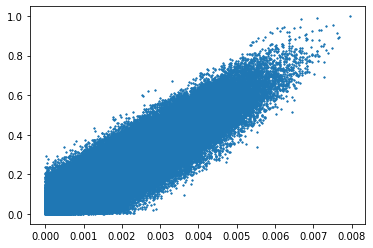

Finished executing completed in 337.49950909614563s


In [6]:
start = time()
xs,ys = energy_trace_compare_p(H1,1,1,proc =processors)
end = time()

mulit_t  = end-start
print(len(xs))

plt.scatter(xs,ys,s=1)
plt.show()

print(f"Finished executing completed in {end-start}s")


In [7]:
print(f"System obtains a speedup of {single_t/mulit_t} using {processors} processors" )

System obtains a speedup of 3.5862604133490112 using 4 processors


### Testing simulation compare

In [26]:
n=11
state1 = tensor([basis(2,0)]*n)
processors = 4
beta0 = lambda n,m: 0
alpha1 = Heisenberg1dRingGen(-1,1,1,n)

H1 = hamiltonian(alpha1,beta0, n)
H1=H1/H1.norm()

assert(H1.isherm)

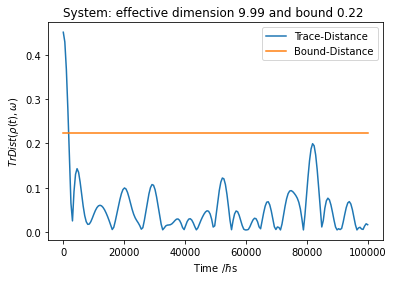

Finished executing completed in 475.26602482795715s


In [27]:
start = time()
equilibration_analyser(H1,state1,1e5,200)
end=time()
print(f"Finished executing completed in {end-start}s")
sim_s = end-start

In [ ]:
start = time()
energys,states = H1.eigenstates()
equilibration_analyser_p(energys,states,state1,0,1e5,200,Proc=4)
end=time()
print(f"Finished executing completed in {end-start}s")
sim_m = end-start

In [29]:
print(f"System obtains a speedup of {sim_s/sim_m} using {processors} processors" )

System obtains a speedup of 0.9512587641197069 using 4 processors
